<a href="https://colab.research.google.com/github/lrc9859/Git-Assignment/blob/master/DL_Lab_1_5_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activation Functions

_Adapted from University of Amsterdam's Deep Learning Tutorials:_
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial3/Activation_Functions.html 

In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [ ]:
# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


## Common activation functions

As a first step, we will implement some common activation functions by ourselves. Of course, most of them can also be found in the `torch.nn` package (see the [documentation](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) for an overview).
However, we'll write our own functions here for a better understanding and insights.

For an easier time of comparing various activation functions, we start with defining a base class from which all our future modules will inherit:

In [ ]:
class ActivationFunction(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.name = self.__class__.__name__
        self.config = {"name": self.name}

Every activation function will be an `nn.Module` so that we can integrate them nicely in a network. We will use the `config` dictionary to store adjustable parameters for some activation functions.

Next, we implement two of the "oldest" activation functions that are still commonly used for various tasks: sigmoid and tanh. 
Both the sigmoid and tanh activation can be also found as PyTorch functions (`torch.sigmoid`, `torch.tanh`) or as modules (`nn.Sigmoid`, `nn.Tanh`). 
Here, we implement them by hand:

###**TanH**

tanh(x) = (e^x – e^-x) / (e^x + e^-x)

In [ ]:
class Tanh(ActivationFunction):
    
    def forward(self, x):
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

###**Sigmoid**

sigmoid(x) = 1/(1 + e^-x)


In [ ]:
class Sigmoid(ActivationFunction):
    
    def forward(self, x):
        return 1 / (1 + torch.exp(-x))

###**ReLU**

ReLU(x) = max(0,x)

In [ ]:
class ReLU(ActivationFunction):
    
    def forward(self, x):
        return x * (x > 0).float()

### **Leaky ReLU**

LeakyReLU(x) = 0.01x if x < 0 else x

In [ ]:
class LeakyReLU(ActivationFunction):
    
    def __init__(self, alpha=0.1):
        super().__init__()
        self.config["alpha"] = alpha
        
    def forward(self, x):
        return torch.where(x > 0, x, self.config["alpha"] * x)

For later usage, we summarize all our activation functions in a dictionary mapping the name to the class object. In case you implement a new activation function by yourself, add it here to include it in future comparisons as well:

In [ ]:
act_fn_by_name = {
    "sigmoid": Sigmoid,
    "tanh": Tanh,
    "relu": ReLU,
    "leakyrelu": LeakyReLU,
}

### Visualizing activation functions

To get an idea of what each activation function actually does, we will visualize them in the following. 
Next to the actual activation value, the gradient of the function is an important aspect as it is crucial for optimizing the neural network. 
PyTorch allows us to compute the gradients simply by calling the `backward` function:

In [ ]:
def get_grads(act_fn, x):
    """
    Computes the gradients of an activation function at specified positions.
    
    Inputs:
        act_fn - An object of the class "ActivationFunction" with an implemented forward pass.
        x - 1D input tensor. 
    Output:
        A tensor with the same size of x containing the gradients of act_fn at x.
    """
    x = x.clone().requires_grad_() # Mark the input as tensor for which we want to store gradients
    out = act_fn(x)
    out.sum().backward() # Summing results in an equal gradient flow to each element in x
    return x.grad # Accessing the gradients of x by "x.grad"

Now we can visualize all our activation functions including their gradients:

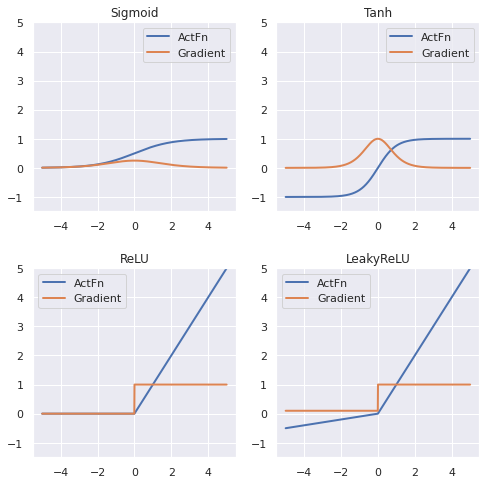

In [ ]:
def vis_act_fn(act_fn, ax, x):
    # Run activation function
    y = act_fn(x)
    y_grads = get_grads(act_fn, x)
    # Push x, y and gradients back to cpu for plotting
    x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()
    ## Plotting
    ax.plot(x, y, linewidth=2, label="ActFn")
    ax.plot(x, y_grads, linewidth=2, label="Gradient")
    ax.set_title(act_fn.name)
    ax.legend()
    ax.set_ylim(-1.5, x.max())

# Add activation functions if wanted
act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000) # Range on which we want to visualize the activation functions
## Plotting
rows = math.ceil(len(act_fns)/2.0)
fig, ax = plt.subplots(rows, 2, figsize=(8, rows*4))
for i, act_fn in enumerate(act_fns):
    vis_act_fn(act_fn, ax[divmod(i,2)], x)
fig.subplots_adjust(hspace=0.3)
plt.show()

# Assignment | Softmax Function

## Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

## Process Dataset

In [ ]:
iris = load_iris()
print(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     

In [ ]:
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

In [ ]:
print(feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [ ]:
print(X)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [ ]:
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [ ]:
print(names)

['setosa' 'versicolor' 'virginica']


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2)

In [ ]:
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 50)
        self.layer3 = nn.Linear(50, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

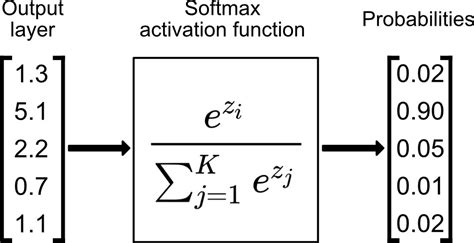

softmax(x1) = (e^x1) / (e^x1 + e^x2 + e^x3 + e^x4)

In [ ]:
model     = Model(4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
print(model)

Model(
  (layer1): Linear(in_features=4, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=3, bias=True)
)


## Model Training

In [ ]:
EPOCHS  = 100

for epoch in range(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    if epoch % 10 == 0:
        print ("Epoch #",epoch)
        print(loss.item())
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward() # Gradients
    optimizer.step() # Update

Epoch # 0
1.0977568626403809
Epoch # 10
0.9996874928474426
Epoch # 20
0.8873593807220459
Epoch # 30
0.7943598031997681
Epoch # 40
0.7375454306602478
Epoch # 50
0.7018430829048157
Epoch # 60
0.6737557649612427
Epoch # 70
0.6480425000190735
Epoch # 80
0.626672089099884
Epoch # 90
0.6110641360282898


## Results

In [ ]:
x_test = Variable((X_test)).float()
with torch.no_grad():
  pred = model(x_test)

In [ ]:
pred = pred.detach().numpy()

In [ ]:
pred[0]

array([9.97747123e-01, 2.14370992e-03, 1.09175926e-04], dtype=float32)

In [ ]:
pred[7]

array([2.3093644e-04, 1.4470355e-02, 9.8529875e-01], dtype=float32)

In [ ]:
pred_dash = np.argmax(pred[0])
print(pred_dash)

0


In [ ]:
pred_dash = np.argmax(pred[7])
print(pred_dash)

2


In [ ]:
x_test[0]

tensor([-1.5065,  0.7888, -1.3402, -1.1838])

In [ ]:
print ("The accuracy is", accuracy_score(y_test, np.argmax(pred, axis=1)))

The accuracy is 0.9333333333333333


# L1 & L2 loss regularizers

## Regularizers

###L1 Regularizer

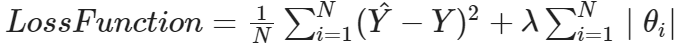


L1 regularization, also known as L1 norm or Lasso regularization, combats overfitting by shrinking the parameters towards 0. This makes some features obsolete.

*   Penalizes the absolute value of the weights.
*   Form of feature selection
*   Sparse solution



###L2 Regularizer

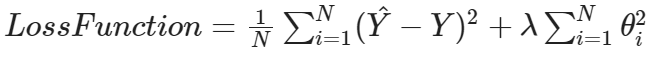

L2 regularization, also known as L2 norm or Ridge regularization, combats overfitting by shrinking the square of the parameters towards 0.

*   Penalizes the relative size of weight
*   Makes them closer to 0
*   Non sparse solution
*   Doesn't handle outliers well



## Standard Linear Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
plt.rcParams['figure.figsize'] = (12,12)

data=pd.read_csv('lin_reg_data.csv')
data.head()

,32.50234527,31.70700585
0,53.426804,68.777596
1,61.530358,62.562382
2,47.475640,71.546632
3,59.813208,87.230925
4,55.142188,78.211518


In [ ]:
 class LinearRegression:
        def __init__(self,X_data,Y_data,l,iterations): #initialize all parameters
            self.X=X_data
            self.Y=Y_data
            #weight and bias
            self.m=0
            self.c=0
            self.L=l #learning rate
            self.iter=iterations #num of iterations
            self.n=float(len(self.X))  #size of data
        
        def cost(self,pred_y): #cost function
            cost=np.sum(np.square(self.Y-pred_y))/(self.n)
            return(cost)
        
        def fit(self):
            self.history=np.zeros(self.iter)
            #updating values of m and c
            for i in range(self.iter):
                pred_y=self.m*X + self.c
                #print(pred_y)
                Dm= (-2/self.n)*(self.X*(self.Y-pred_y))
                Dc= (-2/self.n)*(self.Y-pred_y)
                #update
                self.m=self.m-Dm*self.L
                self.c=self.c-Dc*self.L
                #cost is calculated for every iteration
                self.history[i]=self.cost(pred_y)
            self.mse=self.MSE(self.Y,pred_y)
                
                
                
       
        def MSE(self,pred_y,Y):
            errors=Y-pred_y #error is the difference between actual and predicted value
            mse=np.sum(np.square(errors))/self.n #mean of sum of square of erros
            return mse
        
        def results(self):
            fig=plt.figure(figsize=(14,14))
            a1=fig.add_subplot(211)

            plt.title('minimisation of errors across the iterations')
            a1.plot(self.history)


            #making predictions
            a2=fig.add_subplot(212)
            final_y=self.m*self.X +self.c 
            plt.scatter(self.X,self.Y)
            plt.title('regrssion line')
            a2.plot([min(self.X),max(self.X)],[min(final_y),max(final_y)],color='red') #plotting the red line 
            
            plt.show()
            
            print ('Mean Squared Error=',self.mse)




Plotting the dataset using a scatter plot

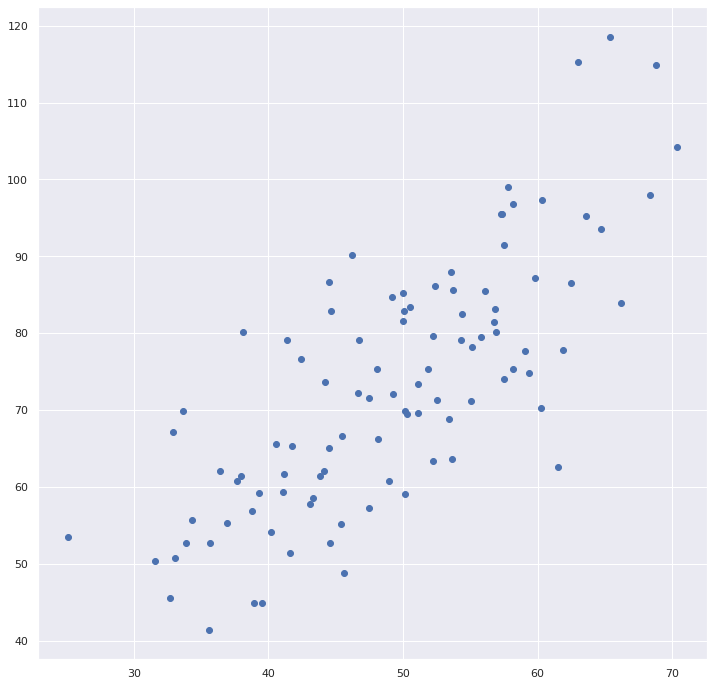

In [ ]:
data=pd.read_csv('lin_reg_data.csv')
data.head()
X=data.iloc[:,0]
Y=data.iloc[:,1]
plt.scatter(X,Y)
plt.show()


In [ ]:
l=LinearRegression(X,Y,0.005,100)

In [ ]:
l.fit()

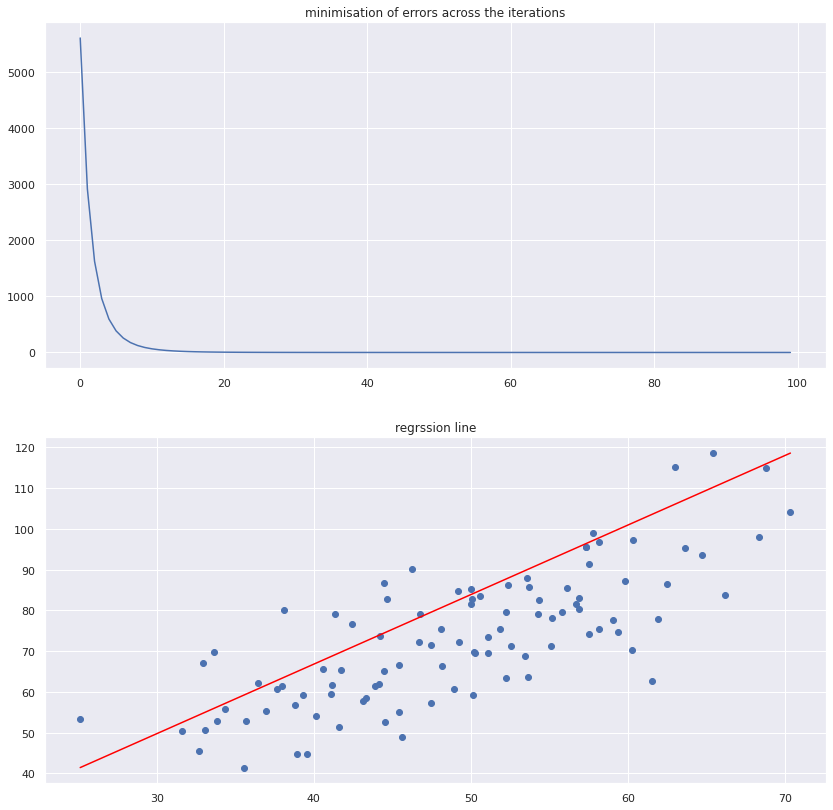

Mean Squared Error= 6.0803681265392814e-05


In [ ]:
l.results()

## Linear Regression with L1 regularizer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
plt.rcParams['figure.figsize'] = (12, 12)

data=pd.read_csv('lin_reg_data.csv')
data.head()

,32.50234527,31.70700585
0,53.426804,68.777596
1,61.530358,62.562382
2,47.475640,71.546632
3,59.813208,87.230925
4,55.142188,78.211518


In [ ]:
 class LinearRegressionL1:
        def __init__(self,X_data,Y_data,l,l1,iterations): #initialize all parameters
            self.X=X_data
            self.Y=Y_data
            #weight and bias
            self.m=np.random.randn(self.X.shape[0])
            self.c=0
            self.L=l #learning rate
            self.l1=l1 #regularization parameter
            self.iter=iterations #num of iterations
            self.n=float(len(X))  #size of data
        
        def cost(self,pred_y): #cost function
            cost=np.sum(np.square(self.Y-pred_y))/(self.n) + self.l1*np.sum(self.m)
            return(cost)
        
        def fit(self):
            self.history=np.zeros(self.iter)
            pred_y=np.zeros((self.Y.shape))
            for j in range(self.iter):
                for i in range(0,len(self.X)):
                        pred_y[i]=self.m[i]*X[i]+self.c
                        if self.m[i]>0:
                            Dm= (-2/self.n)*(self.X[i]*(self.Y[i]-pred_y[i]))-self.l1 
                        else:
                            Dm= (-2/self.n)*(self.X[i]*(self.Y[i]-pred_y[i]))+self.l1


                        Dc= (-2/self.n)*(self.Y[i]-pred_y[i])
                        #update
                        self.m[i]=self.m[i]-Dm*self.L
                        self.c=self.c-Dc*self.L
                self.history[j]=self.cost(pred_y)
            self.mse=self.MSE(self.Y,pred_y)

              
       
        def MSE(self,pred_y,Y):
            errors=Y-pred_y #error is the difference between actual and predicted value
            mse=np.sum(np.square(errors))/self.n #mean of sum of square of erros
            return mse
        
        def results(self):
            fig=plt.figure(figsize=(14,14))
            a1=fig.add_subplot(211)

            plt.title('minimisation of errors across the iterations')
            a1.plot(self.history)


            #making predictions
            a2=fig.add_subplot(212)
            final_y=self.m*self.X +self.c 
            plt.scatter(self.X,self.Y)
            plt.title('regrssion line')
            a2.plot([min(self.X),max(self.X)],[min(final_y),max(final_y)],color='red') #plotting the red line 
            
            plt.show()
            
            print ('Mean Squared Error=',self.mse)




Plotting the dataset using a scatter plot

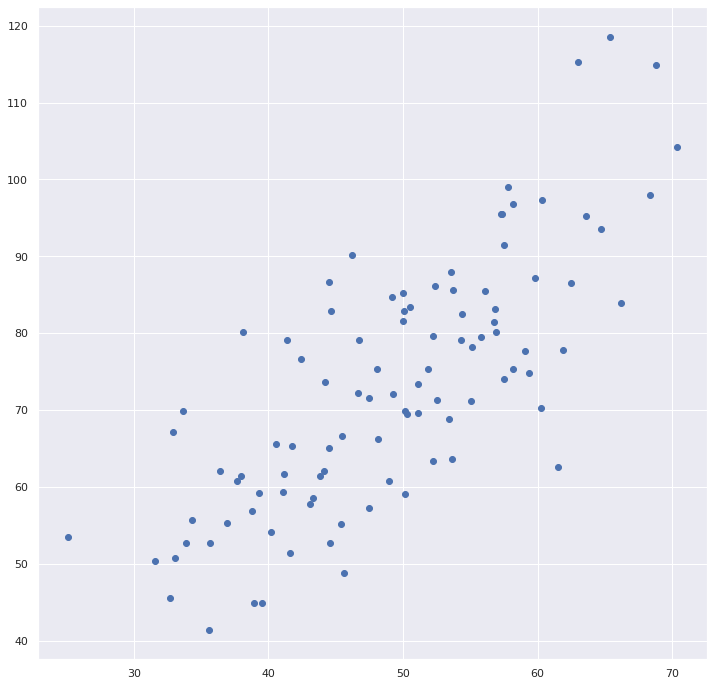

In [ ]:
data=pd.read_csv('lin_reg_data.csv')
data.head()
X=data.iloc[:,0]
Y=data.iloc[:,1]
plt.scatter(X,Y)
plt.show()


In [ ]:
l=LinearRegressionL1(X,Y,0.005,0.001,100)

In [ ]:
l.fit()

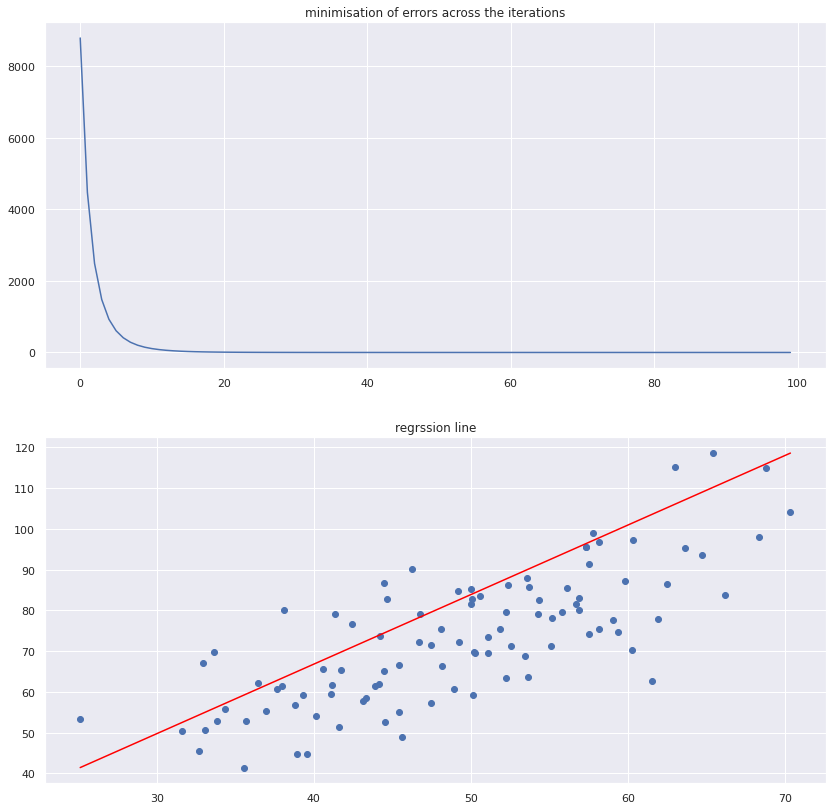

Mean Squared Error= 8.032949276079813e-05


In [ ]:
l.results()

## Linear Regression with L2 regularizer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as st
plt.rcParams['figure.figsize'] = (12, 12)

data=pd.read_csv('lin_reg_data.csv')
data.head()

,32.50234527,31.70700585
0,53.426804,68.777596
1,61.530358,62.562382
2,47.475640,71.546632
3,59.813208,87.230925
4,55.142188,78.211518


In [ ]:
 class LinearRegressionL2:
        def __init__(self,X_data,Y_data,l,l2,iterations): #initialize all parameters
            self.X=X_data
            self.Y=Y_data
            #weight and bias
            self.m=0
            self.c=0
            self.L=l #learning rate
            self.l2=l2 #regularization parameter
            self.iter=iterations #num of iterations
            self.n=float(len(self.X))  #size of data
        
        def cost(self,pred_y): #cost function
            cost=np.sum(np.square(self.Y-pred_y))/(self.n) + self.l2*np.sum(np.square(self.m))
            return(cost)
        
        def fit(self):
            self.history=np.zeros(self.iter)
            #updating values of m and c
            for i in range(self.iter):
                pred_y=self.m*self.X + self.c
                #print(pred_y)
                Dm= (-2/self.n)*(self.X*(self.Y-pred_y))+2*self.l2*self.m
                Dc= (-2/self.n)*(self.Y-pred_y)
                #update
                self.m=self.m-Dm*self.L
                self.c=self.c-Dc*self.L
                #cost is calculated for every iteration
                self.history[i]=self.cost(pred_y)
            self.mse=self.MSE(self.Y,pred_y)
                
                
                
       
        def MSE(self,pred_y,Y):
            errors=Y-pred_y #error is the difference between actual and predicted value
            mse=np.sum(np.square(errors))/self.n #mean of sum of square of erros
            return mse
        
        def results(self):
            fig=plt.figure(figsize=(14,14))
            a1=fig.add_subplot(211)

            plt.title('minimisation of errors across the iterations')
            a1.plot(self.history)


            #making predictions
            a2=fig.add_subplot(212)
            final_y=self.m*self.X +self.c 
            plt.scatter(self.X,self.Y)
            plt.title('regrssion line')
            a2.plot([min(self.X),max(self.X)],[min(final_y),max(final_y)],color='red') #plotting the red line 
            
            plt.show()
            
            print ('Mean Squared Error=',self.mse)




Plotting the dataset using a scatter plot

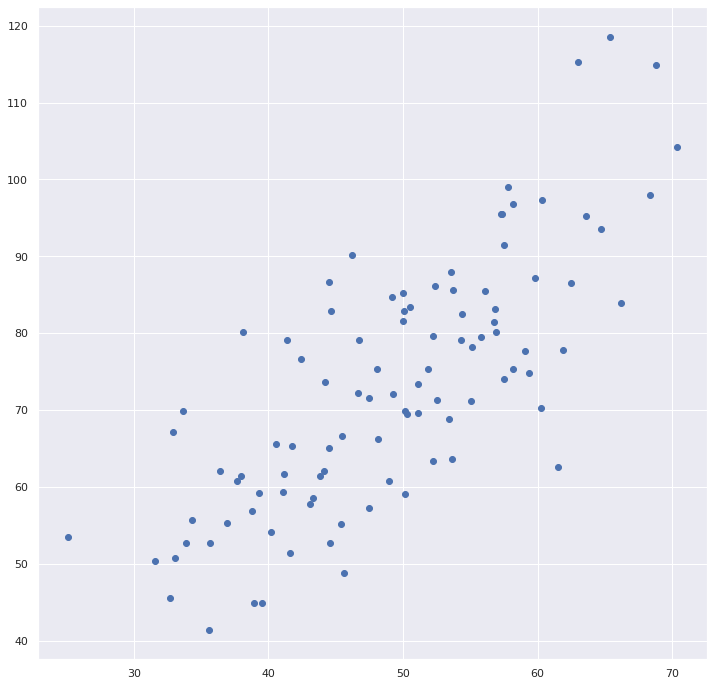

In [ ]:
data=pd.read_csv('lin_reg_data.csv')
data.head()
X=data.iloc[:,0]
Y=data.iloc[:,1]
plt.scatter(X,Y)
plt.show()


In [ ]:
l=LinearRegressionL2(X,Y,0.005,0.001,100)

In [ ]:
l.fit()

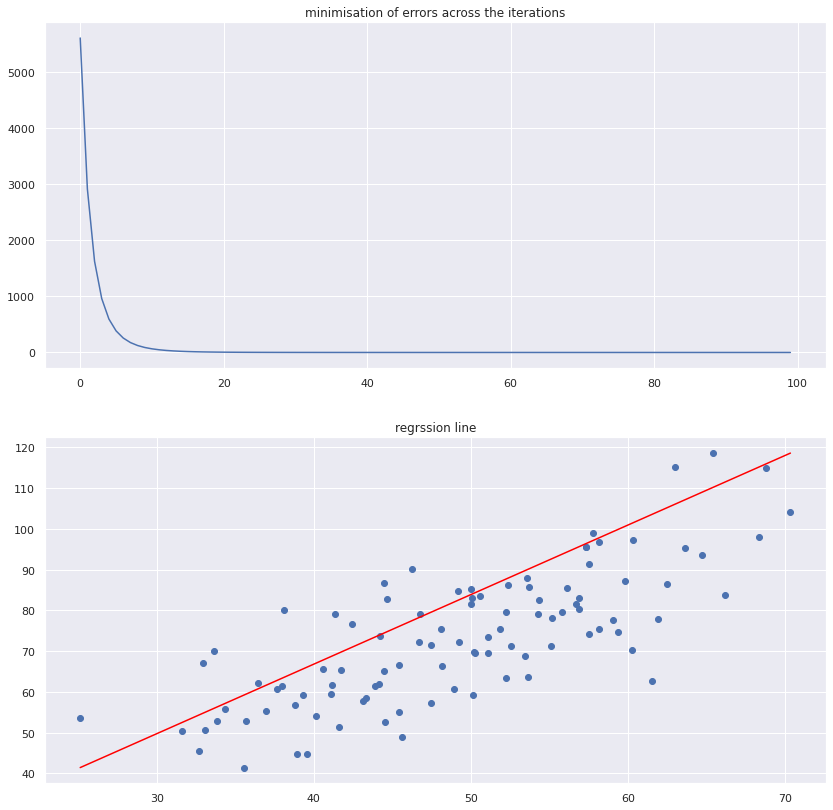

Mean Squared Error= 8.5291379739768e-05


In [ ]:
l.results()

## L2 regression using pytorch

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)